In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import zipfile
import os
import ipywidgets as widgets
from IPython.display import display

# Load the Dataset

[Download the dataset from Kaggle](https://www.kaggle.com/datasets/threnjen/board-games-database-from-boardgamegeek/data?select=games.csv) and place in project folder `/data`. Rename the zipfile such that you have: `/data/board-games.zip` before running the next cell.

In [23]:
# Unzip the dataset
zip_path = 'data/board-games.zip'
extract_folder = 'data'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
        print(zip_path, " extracted successfully.")
else:
    print("Error: The file {zip_path} does not exist. Please check the path.")

data/board-games.zip  extracted successfully.


In [24]:
# Load the tables as dataframes
games = pd.read_csv('data/games.csv')
ratings_distribution = pd.read_csv('data/ratings_distribution.csv')
mechanics = pd.read_csv('data/mechanics.csv')
subcategories = pd.read_csv('data/subcategories.csv')
themes = pd.read_csv('data/themes.csv')
user_ratings = pd.read_csv('data/user_ratings.csv')

# Store the dataframes in a list for easy access, use the table names as keys
dataset = {
    'games': games,
    'ratings_distribution': ratings_distribution,
    'mechanics': mechanics,
    'subcategories': subcategories,
    'themes': themes,
    'user_ratings': user_ratings
}
print("Tables... ", dataset.keys(), " loaded successfully as dataframes.")


Tables...  dict_keys(['games', 'ratings_distribution', 'mechanics', 'subcategories', 'themes', 'user_ratings'])  loaded successfully as dataframes.


In [25]:
# Clean the data

# Convert mechanics binary indicators to integers
for col in dataset['mechanics']:
    if col != 'BGGId':
        dataset['mechanics'][col] = dataset['mechanics'][col].astype(int)
print("Mechanics cleaned successfully.")

for col in dataset['themes']:
    if col != 'BGGId':
        dataset['themes'][col] = dataset['themes'][col].astype(int)
print("Themes cleaned successfully.")

for col in dataset['subcategories']:
    if col != 'BGGId':
        dataset['subcategories'][col] = dataset['subcategories'][col].astype(int)
print("Subcategories cleaned successfully.")

# Prefixing column names in the 'mechanics', 'themes', and 'subcategories' dataframes before merging
mechanic_prefix = '(mechanic) '
theme_prefix = '(theme) '
subcategory_prefix = '(subcategory) '
# Add prefixes to the column names, avoiding the BGGId column
dataset['mechanics'] = dataset['mechanics'].rename(columns=lambda x: mechanic_prefix + x if x != 'BGGId' else x)
dataset['themes'] = dataset['themes'].rename(columns=lambda x: theme_prefix + x if x != 'BGGId' else x)
dataset['subcategories'] = dataset['subcategories'].rename(
    columns=lambda x: subcategory_prefix + x if x != 'BGGId' else x)
print("Column names prefixed successfully.")

Mechanics cleaned successfully.
Themes cleaned successfully.
Subcategories cleaned successfully.
Column names prefixed successfully.


## Visualize Dataset

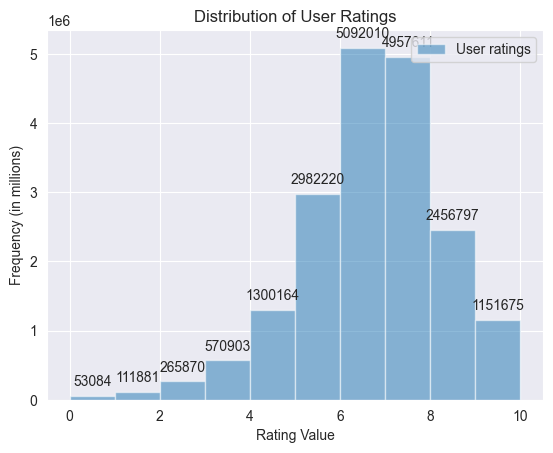

In [26]:
# Visualize the data
# Plot the distribution of ratings using user_ratings
plt.hist(dataset['user_ratings']['Rating'], bins=10, alpha=0.5, label='User ratings')

# Recalculate the histogram to get the counts, bins, and patches
counts, bins, patches = plt.hist(dataset['user_ratings']['Rating'], bins=10, alpha=0)

# Add annotations to each bar with the exact counts, placing them flush with the bottom of the bar
for count, patch in zip(counts, patches):
    plt.annotate(str(int(count)), xy=(patch.get_x() + patch.get_width() / 2, patch.get_height()), xytext=(0, 5),
                 textcoords='offset points', ha='center', va='bottom')

plt.title('Distribution of User Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Frequency (in millions)')
plt.legend(loc='upper right')
plt.show()

#### Analysis of the User Ratings Distribution

The distribution of user ratings is skewed to the right, with most games having a rating between `6` and `8`. I would expect any models created from this to have a bias towards predicting ratings in this range based on this distributions lack of symmetry especially in the lower ratings. There are several strategies to deal with this, such as using a different loss function or oversampling the lower ratings to balance the dataset.

Correlation calculated between Total Mechanics and Average Rating:  0.6433536535281515


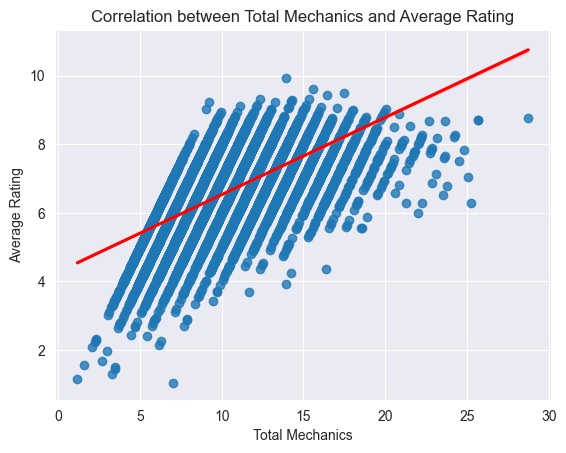

In [27]:
# Explore the games and mechanics correlation
# Merge the games and mechanics dataframes
games_mechanics = pd.merge(dataset['games'][['BGGId', 'AvgRating']], dataset['mechanics'], on='BGGId')

# Calculate the total number of mechanics for each game
# Assuming all the other columns in mechanics are binary  indicators of whether a game has a particular mechanic
mechanic_columns = [col for col in games_mechanics.columns if col != 'BGGId']
games_mechanics['TotalMechanics'] = games_mechanics[mechanic_columns].sum(axis=1)

# Calculate the correlation between the total number of mechanics and the average rating
correlation = games_mechanics[['TotalMechanics', 'AvgRating']].corr().iloc[0, 1]
print("Correlation calculated between Total Mechanics and Average Rating: ", correlation)

# Plot scatter plot correlation with a regression line
sns.regplot(x='TotalMechanics', y='AvgRating', data=games_mechanics, line_kws={'color': 'red'})
plt.title('Correlation between Total Mechanics and Average Rating')
plt.xlabel('Total Mechanics')
plt.ylabel('Average Rating')
plt.show()

#### Analysis of the Total Mechanics and Average Rating Correlation

The correlation between the total number of mechanics and the average rating is .64, which is a moderate positive correlation. This suggests that games with more mechanics tend towards a higher average rating, but with a only moderate correlation it suggests too many mechanics could be detrimental to the rating. This is a good sign for our model, as it suggests that the number of mechanics could be a good predictor of the average rating in combination with other features.

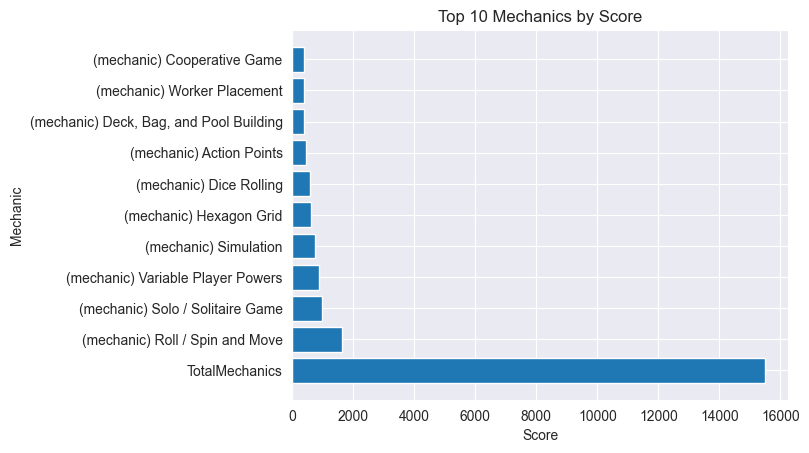

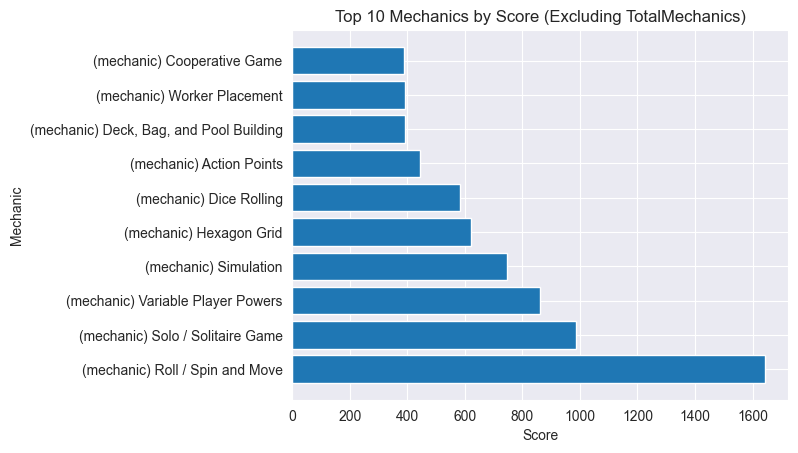

In [28]:
# Attempt to extract the top 10 mechanics using Sklearn's SelectKBest
X = games_mechanics.drop(columns=['BGGId', 'AvgRating'])
y = games_mechanics['AvgRating']

# Select the best features
best_features = SelectKBest(score_func=f_regression, k=11)
fit = best_features.fit(X, y)

# Summarize scores
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concatenate the dataframes
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
# print(feature_scores.nlargest(11, 'Score'))

# Plot the scores with the TotalMechanics column
plt.barh(feature_scores.nlargest(11, 'Score')['Feature'], feature_scores.nlargest(11, 'Score')['Score'])
plt.title('Top 10 Mechanics by Score')
plt.xlabel('Score')
plt.ylabel('Mechanic')
plt.show()

# Select the best features without the TotalMechanics column
X = X.drop(columns='TotalMechanics')
best_features = SelectKBest(score_func=f_regression, k=10)
fit = best_features.fit(X, y)

# Recalculate the scores
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concatenate the dataframes
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
# print(feature_scores.nlargest(10, 'Score'))

# Plot the scores without the TotalMechanics column
plt.barh(feature_scores.nlargest(10, 'Score')['Feature'], feature_scores.nlargest(10, 'Score')['Score'])
plt.title('Top 10 Mechanics by Score (Excluding TotalMechanics)')
plt.xlabel('Score')
plt.ylabel('Mechanic')
plt.show()

#### Analysis of the Top 10 Mechanics by Score

Further exploration of the game mechanics data shows the impact of individual mechanics on the average rating. The top 10 mechanics by Sklearn's feature score are shown in the charts above. The TotalMechanics feature is also included in the first chart to show relative impact on the average rating because we know TotalMechanics has a moderate correlation with the average rating. This shows us that an individual mechanic even the most impactful of the 150+ tracked has a relatively small impact on the average rating.

Correlation calculated between Total Themes and Average Rating:  0.6956086420954524


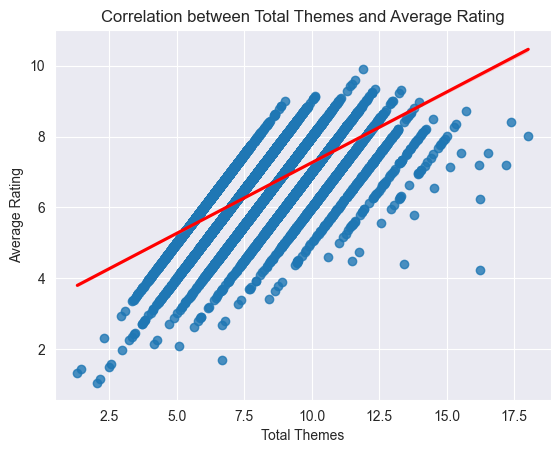

In [29]:
# Explore the themes correlation with the average rating
# Will use the same approach as with the mechanics

# Merge the games and themes dataframes
games_themes = pd.merge(dataset['games'][['BGGId', 'AvgRating']], dataset['themes'], on='BGGId')

# Calculate the total number of themes for each game
# Assuming all the other columns in themes are binary  indicators of whether a game has a particular theme
theme_columns = [col for col in games_themes.columns if col != 'BGGId']
games_themes['TotalThemes'] = games_themes[theme_columns].sum(axis=1)

# Calculate the correlation between the total number of themes and the average rating
correlation = games_themes[['TotalThemes', 'AvgRating']].corr().iloc[0, 1]
print("Correlation calculated between Total Themes and Average Rating: ", correlation)

# Plot scatter plot correlation with a regression line
sns.regplot(x='TotalThemes', y='AvgRating', data=games_themes, line_kws={'color': 'red'})
plt.title('Correlation between Total Themes and Average Rating')
plt.xlabel('Total Themes')
plt.ylabel('Average Rating')
plt.show()

#### Analysis of the Total Themes and Average Rating Correlation

The correlation between the total number of themes and the average rating is .69, which is a moderate positive correlation. This suggests that games with more themes tend towards a higher average rating, but with a only moderate correlation it suggests too many themes could be detrimental to the rating. This is a good sign for our model, as it suggests that the number of themes could be a good predictor of the average rating in combination with other features such as the also moderately correlated TotalMechanics feature.

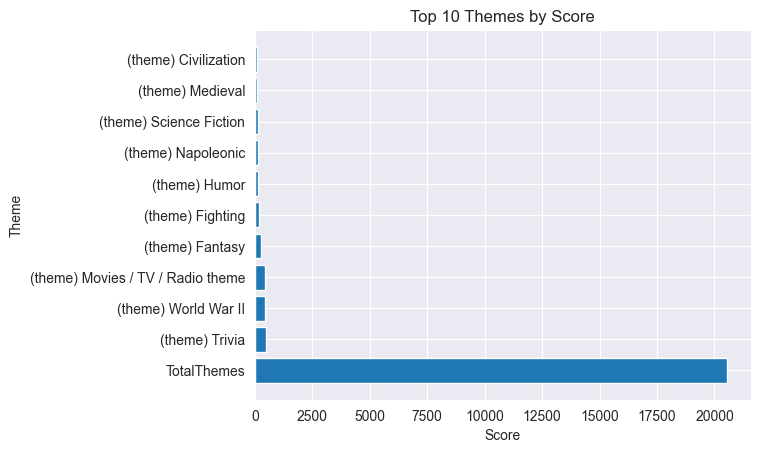

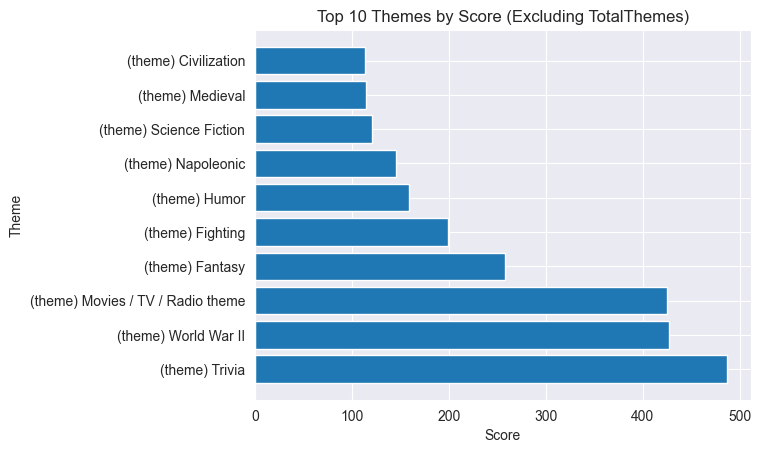

In [30]:
# Attempt to extract the top 10 themes using Sklearn's SelectKBest
X = games_themes.drop(columns=['BGGId', 'AvgRating'])
y = games_themes['AvgRating']

# Select the best features
best_features = SelectKBest(score_func=f_regression, k=11)
fit = best_features.fit(X, y)

# Summarize scores
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concatenate the dataframes
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
# print(feature_scores.nlargest(11, 'Score'))

# Plot the scores with the TotalThemes column
plt.barh(feature_scores.nlargest(11, 'Score')['Feature'], feature_scores.nlargest(11, 'Score')['Score'])
plt.title('Top 10 Themes by Score')
plt.xlabel('Score')
plt.ylabel('Theme')
plt.show()

# Select the best features without the TotalThemes column
X = X.drop(columns='TotalThemes')
best_features = SelectKBest(score_func=f_regression, k=10)
fit = best_features.fit(X, y)

# Recalculate the scores
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concatenate the dataframes
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
# print(feature_scores.nlargest(10, 'Score'))

# Plot the scores without the TotalThemes column
plt.barh(feature_scores.nlargest(10, 'Score')['Feature'], feature_scores.nlargest(10, 'Score')['Score'])
plt.title('Top 10 Themes by Score (Excluding TotalThemes)')
plt.xlabel('Score')
plt.ylabel('Theme')
plt.show()

#### Analysis of the Top 10 Themes by Score

Further exploration of the game themes data shows the impact of individual themes on the average rating. The top 10 themes by Sklearn's feature score are shown in the charts above. The TotalThemes feature is also included in the first chart to show relative impact on the average rating because we know TotalThemes has a moderate correlation with the average rating. This shows us that an individual theme has very little impact on the average rating. Even less so than the scores for the individual mechanics.

Correlation calculated between Total Subcategories and Average Rating:  0.8248388642563783


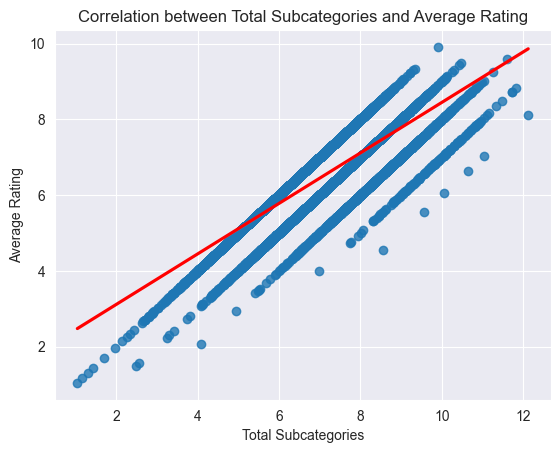

In [31]:
# Explore the subcategories correlation with the average rating
# Will use the same approach as with the mechanics and themes

# Merge the games and subcategories dataframes
games_subcategories = pd.merge(dataset['games'][['BGGId', 'AvgRating']], dataset['subcategories'], on='BGGId')

# Calculate the total number of subcategories for each game
# Assuming all the other columns in subcategories are binary  indicators of whether a game has a particular subcategory
subcategory_columns = [col for col in games_subcategories.columns if col != 'BGGId']
games_subcategories['TotalSubcategories'] = games_subcategories[subcategory_columns].sum(axis=1)

# Calculate the correlation between the total number of subcategories and the average rating
correlation = games_subcategories[['TotalSubcategories', 'AvgRating']].corr().iloc[0, 1]
print("Correlation calculated between Total Subcategories and Average Rating: ", correlation)

# Plot scatter plot correlation with a regression line
sns.regplot(x='TotalSubcategories', y='AvgRating', data=games_subcategories, line_kws={'color': 'red'})
plt.title('Correlation between Total Subcategories and Average Rating')
plt.xlabel('Total Subcategories')
plt.ylabel('Average Rating')
plt.show()

#### Analysis of the Total Subcategories and Average Rating Correlation

The correlation between the total number of subcategories and the average rating is .82, a strong positive correlation. This suggests that games with more subcategories tend towards a higher average rating. This is a good sign for our model, as it suggests that the number of subcategories could be a good predictor of the average rating in combination with other features such as the moderately correlated TotalMechanics and TotalThemes features.

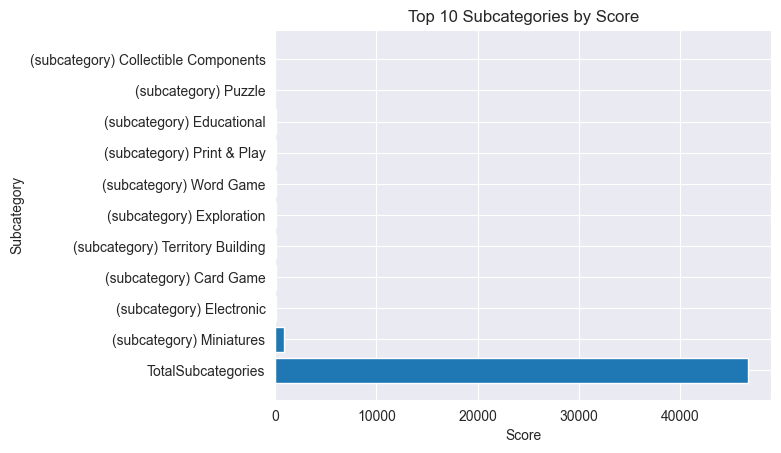

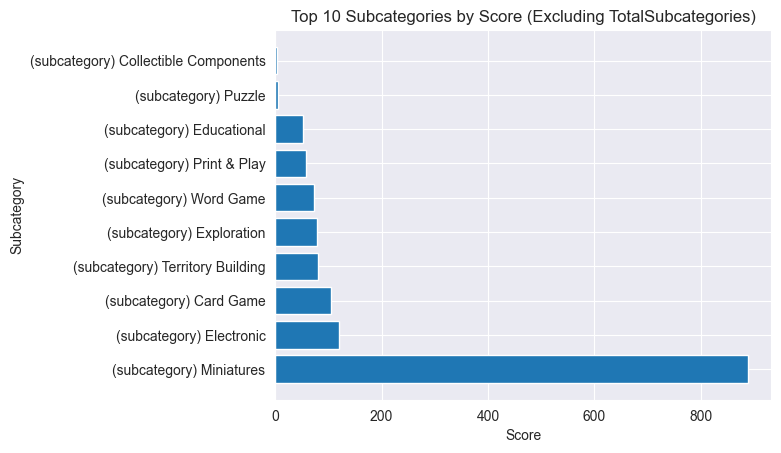

In [32]:
# Attempt to extract the top 10 subcategories using Sklearn's SelectKBest
X = games_subcategories.drop(columns=['BGGId', 'AvgRating'])
y = games_subcategories['AvgRating']

# Select the best features
best_features = SelectKBest(score_func=f_regression, k=11)
fit = best_features.fit(X, y)

# Summarize scores
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concatenate the dataframes
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
# print(feature_scores.nlargest(11, 'Score'))

# Plot the scores with the TotalSubcategories column
plt.barh(feature_scores.nlargest(11, 'Score')['Feature'], feature_scores.nlargest(11, 'Score')['Score'])
plt.title('Top 10 Subcategories by Score')
plt.xlabel('Score')
plt.ylabel('Subcategory')
plt.show()

# Select the best features without the TotalSubcategories column
X = X.drop(columns='TotalSubcategories')
best_features = SelectKBest(score_func=f_regression, k=10)
fit = best_features.fit(X, y)

# Recalculate the scores
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concatenate the dataframes
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
# print(feature_scores.nlargest(10, 'Score'))

# Plot the scores without the TotalSubcategories column
plt.barh(feature_scores.nlargest(10, 'Score')['Feature'], feature_scores.nlargest(10, 'Score')['Score'])
plt.title('Top 10 Subcategories by Score (Excluding TotalSubcategories)')
plt.xlabel('Score')
plt.ylabel('Subcategory')
plt.show()

#### Analysis of the Top 10 Subcategories by Score

Further exploration of the game subcategories data shows the impact of individual subcategories on the average rating. The top 10 subcategories by Sklearn's feature score are shown in the charts above. The TotalSubcategories feature is also included in the first chart to show relative impact on the average rating because we know TotalSubcategories has a strong correlation with the average rating. This shows us that an individual subcategory has a relatively small impact on the average rating, even less so than the scores for the individual mechanics and themes. This makes total subcategories the  strongest feature so far, but also suggests that the individual subcategories are not very impactful.

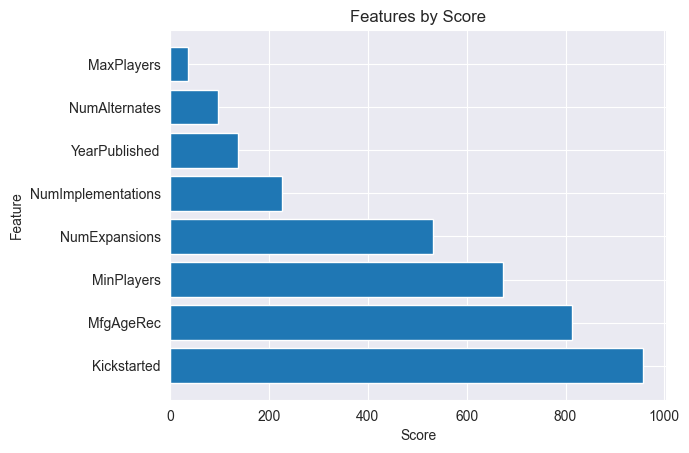

In [33]:
# Use Sklearn's SelectKBest to extract the top 10 features from the games dataframe
# Start by identifying the feature columns
# BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,ComAgeRec,LanguageEase,BestPlayers,GoodPlayers,NumOwned,NumWant,NumWish,NumWeightVotes,MfgPlaytime,ComMinPlaytime,ComMaxPlaytime,MfgAgeRec,NumUserRatings,NumComments,NumAlternates,NumExpansions,NumImplementations,IsReimplementation,Family,Kickstarted,ImagePath,Rank:boardgame,Rank:strategygames,Rank:abstracts,Rank:familygames,Rank:thematic,Rank:cgs,Rank:wargames,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens

# Only select the columns that can be used as features
valid_features = ['YearPublished', 'MinPlayers', 'MaxPlayers', 'MfgAgeRec', 'NumAlternates', 'NumExpansions',
                  'NumImplementations', 'Kickstarted']
X = dataset['games'][valid_features]
y = dataset['games']['AvgRating']

# Select the best features
best_features = SelectKBest(score_func=f_regression, k=len(valid_features))
fit = best_features.fit(X, y)

# Summarize scores
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concatenate the dataframes
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
# print(feature_scores.nlargest(len(valid_features), 'Score'))

# Plot the scores
plt.barh(feature_scores.nlargest(len(valid_features), 'Score')['Feature'],
         feature_scores.nlargest(len(valid_features), 'Score')['Score'])
plt.title('Features by Score')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

#### Analysis of the Features by Score

There are many features on the games table to explore, but some of them will be irrelevant to our model because only features that could be known about a game before it is published can be used to predict the average rating. Using Sklearn's SelectKBest we score the features and plot the results. The top features found are: Kickstarted, MfgAgeRec, MinPlayers, and NumExpansions.  These features are the most impactful on the average rating out of the features examined, but the scores are still relatively low. This suggests that the individual features are not very impactful on the average rating.

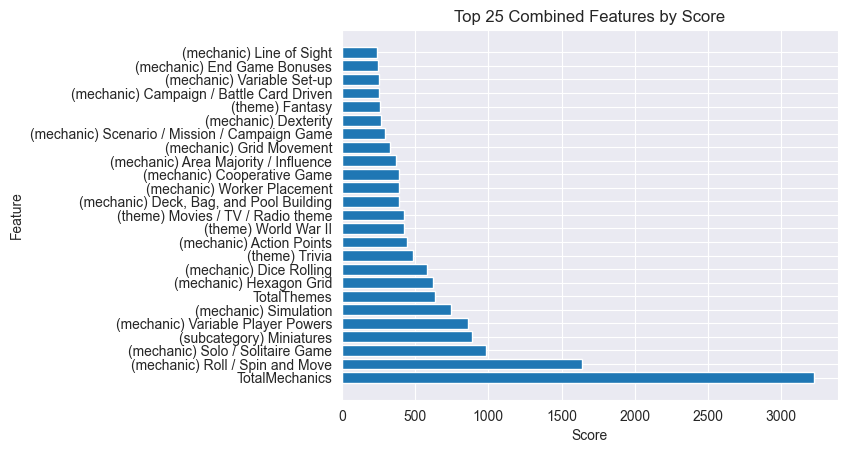

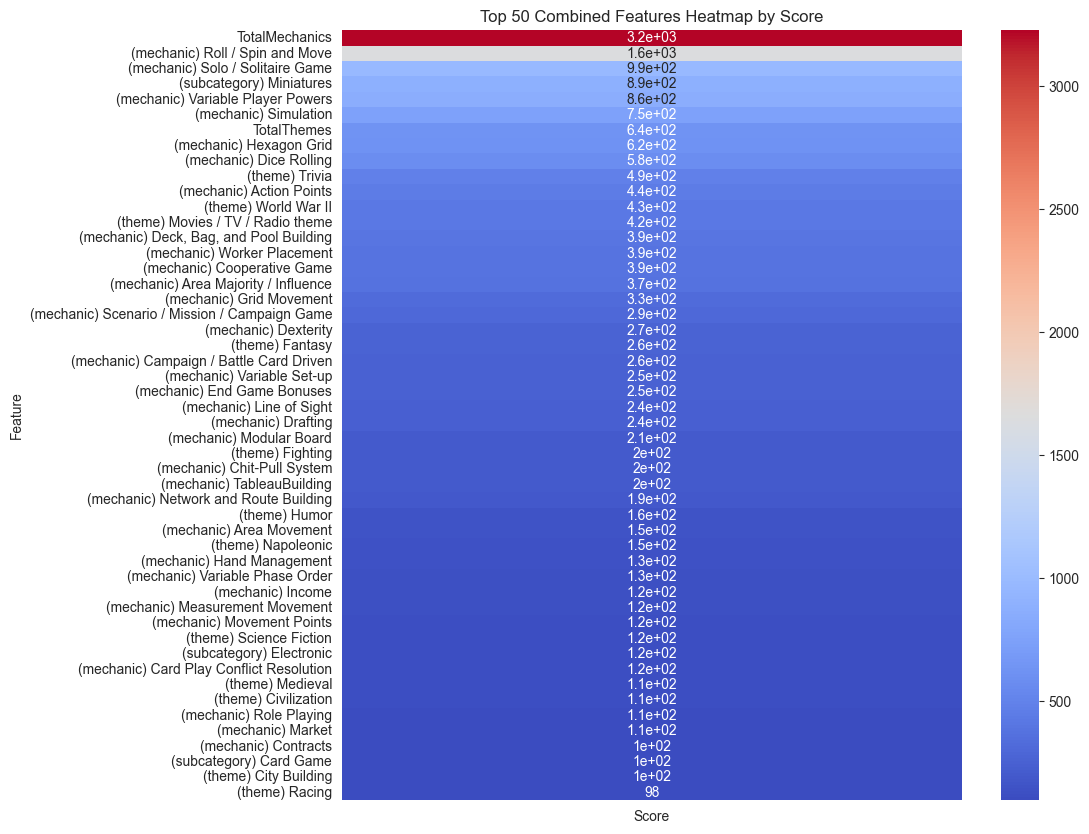

In [34]:
# We now have evaluated several features from the games, mechanics, themes, and subcategories tables. We will now combine and score the features together.

# Merge the games, mechanics, themes, and subcategories dataframes
dataset['game_features'] = pd.merge(dataset['games'][['BGGId', 'AvgRating']], dataset['mechanics'], on='BGGId')
dataset['game_features'] = pd.merge(dataset['game_features'], dataset['themes'], on='BGGId')
dataset['game_features'] = pd.merge(dataset['game_features'], dataset['subcategories'], on='BGGId')

# Calculate the total number of mechanics, themes, and subcategories for each game
# Assuming all the other columns in mechanics, themes, and subcategories are binary  indicators of whether a game has a particular mechanic, theme, or subcategory
mechanic_columns = [col for col in dataset['mechanics'].columns if col != 'BGGId']
theme_columns = [col for col in dataset['themes'].columns if col != 'BGGId']
subcategory_columns = [col for col in dataset['subcategories'].columns if col != 'BGGId']

dataset['game_features']['TotalMechanics'] = dataset['game_features'][mechanic_columns].sum(axis=1)
dataset['game_features']['TotalThemes'] = dataset['game_features'][theme_columns].sum(axis=1)
dataset['game_features']['TotalSubcategories'] = dataset['game_features'][subcategory_columns].sum(axis=1)

# Select the best features
X = dataset['game_features'].drop(columns=['BGGId', 'AvgRating'])
y = dataset['game_features']['AvgRating']
best_features = SelectKBest(score_func=f_regression, k=len(X.columns))

# Fit the model
fit = best_features.fit(X, y)

# Summarize scores
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concatenate the dataframes
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
# print(feature_scores.nlargest(len(X.columns), 'Score'))

# Plot the scores
plt.barh(feature_scores.nlargest(25, 'Score')['Feature'],
         feature_scores.nlargest(25, 'Score')['Score'])
plt.title('Top 25 Combined Features by Score')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.show()

# Display as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(feature_scores.nlargest(50, 'Score').set_index('Feature'), annot=True, cmap='coolwarm')
plt.title('Top 50 Combined Features Heatmap by Score')
plt.show()

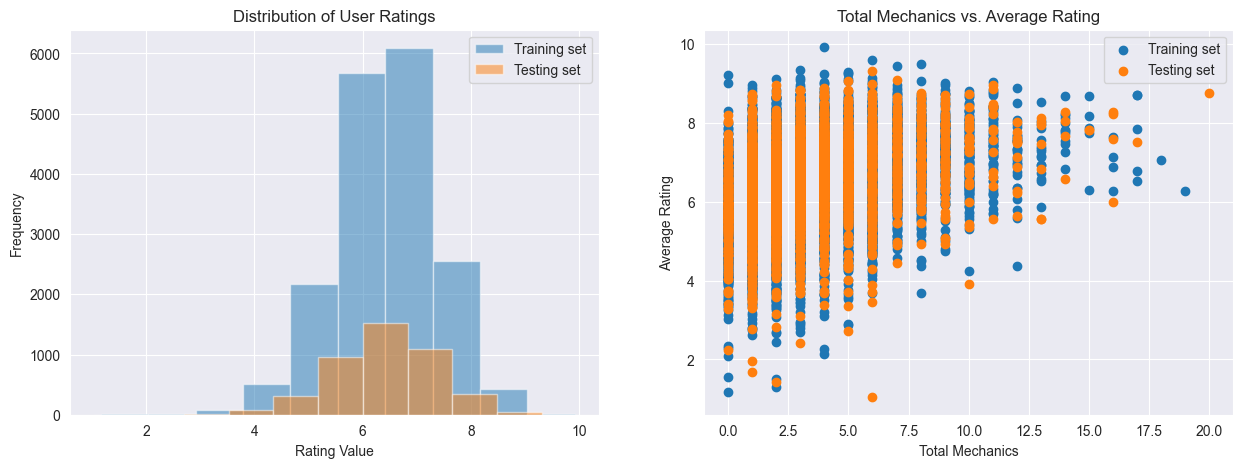

In [35]:
# Split the data into training and testing sets
# Reserve 20% of the data for testing, and use the remaining 80% for training
# We will use the TotalMechanics, TotalThemes, and TotalSubcategories features
X = dataset['game_features'][['TotalMechanics', 'TotalThemes', 'TotalSubcategories']]
y = dataset['game_features']['AvgRating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize the Mechanic, Theme, and Subcategory data split
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(y_train, bins=10, alpha=0.5, label='Training set')
ax[0].hist(y_test, bins=10, alpha=0.5, label='Testing set')
ax[0].set_title('Distribution of User Ratings')
ax[0].set_xlabel('Rating Value')
ax[0].set_ylabel('Frequency')
ax[0].legend(loc='upper right')

ax[1].scatter(X_train['TotalMechanics'], y_train, label='Training set')
ax[1].scatter(X_test['TotalMechanics'], y_test, label='Testing set')
ax[1].set_title('Total Mechanics vs. Average Rating')
ax[1].set_xlabel('Total Mechanics')
ax[1].set_ylabel('Average Rating')
ax[1].legend(loc='upper right')

plt.show()


## Create and Test ML Models

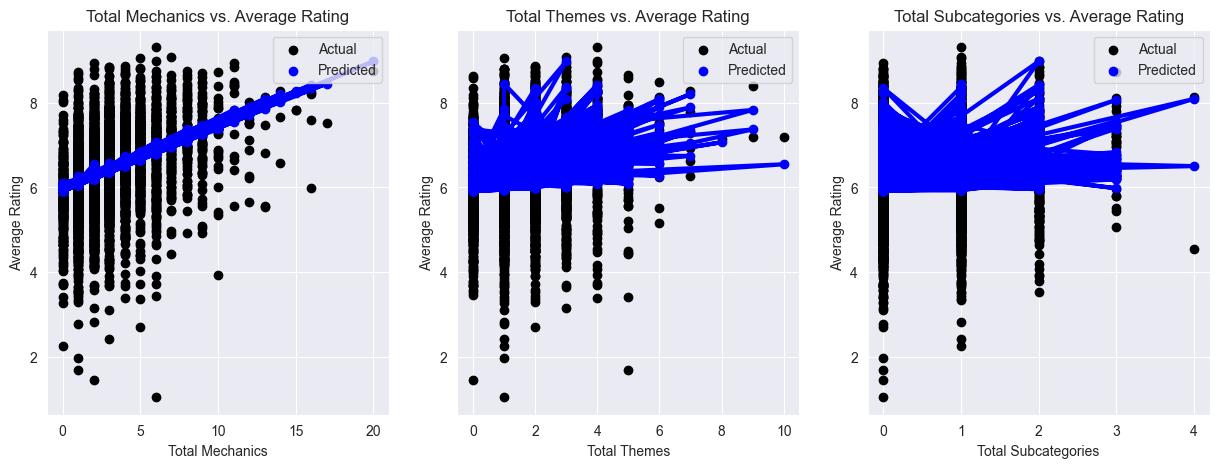

Coefficients: 
 [0.14616347 0.03172551 0.02137348]
Mean squared error: 0.80
Coefficient of determination: 0.13


In [36]:
# Create a linear regression model
model = LinearRegression()

# Train the model using the training sets
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot outputs
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(X_test['TotalMechanics'], y_test, color='black', label='Actual')
ax[0].scatter(X_test['TotalMechanics'], y_pred, color='blue', label='Predicted')
ax[0].plot(X_test['TotalMechanics'], y_pred, color='blue', linewidth=3)
ax[0].set_title('Total Mechanics vs. Average Rating')
ax[0].set_xlabel('Total Mechanics')
ax[0].set_ylabel('Average Rating')
ax[0].legend(loc='upper right')

ax[1].scatter(X_test['TotalThemes'], y_test, color='black', label='Actual')
ax[1].scatter(X_test['TotalThemes'], y_pred, color='blue', label='Predicted')
ax[1].plot(X_test['TotalThemes'], y_pred, color='blue', linewidth=3)
ax[1].set_title('Total Themes vs. Average Rating')
ax[1].set_xlabel('Total Themes')
ax[1].set_ylabel('Average Rating')
ax[1].legend(loc='upper right')

ax[2].scatter(X_test['TotalSubcategories'], y_test, color='black', label='Actual')
ax[2].scatter(X_test['TotalSubcategories'], y_pred, color='blue', label='Predicted')
ax[2].plot(X_test['TotalSubcategories'], y_pred, color='blue', linewidth=3)
ax[2].set_title('Total Subcategories vs. Average Rating')
ax[2].set_xlabel('Total Subcategories')
ax[2].set_ylabel('Average Rating')
ax[2].legend(loc='upper right')
plt.show()

# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % sk.metrics.mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % sk.metrics.r2_score(y_test, y_pred))


## Linear Regression Model Analysis (TotalMechanics, TotalThemes, and TotalSubcategories)

Using linear regression to predict the average rating based on the TotalMechanics, TotalThemes, and TotalSubcategories features, we get coefficients .14, .03, and .02, respectively. That means that for each one-unit increase in each feature, there was an estimated change in the coefficient value to the predicted rating. The mean square error was .80, and the coefficient of determination was .13. This suggests the model was inaccurate, but it did have some predictive power beyond taking the mean. The mean square error of .80 was good, considering the range for average rating is 0-10. On the other hand, the coefficient of determination was high enough to have predictive power but low enough to be sure there were more features capable of influencing the average rating significantly.   

The scatter plots show the actual and predicted average ratings for each feature. The predicted average ratings are very close to the actual average ratings for the TotalMechanics feature but not as close to the TotalThemes and TotalSubcategories features. This suggested that the model was better at predicting the average rating based on the TotalMechanics feature than the other features. This is consistent with the feature scores calculated earlier in the data processing, which showed that the TotalMechanics feature had the highest score of the three features. This also aligns with an intuitive view of the scatter plots, which show a more linear relationship between the TotalMechanics feature and the average rating than the other features. 

In [37]:
# Repeat the process using the dataset with all features from the games, mechanics, themes, and subcategories tables
# Split the data into training and testing sets
# Reserve 20% of the data for testing, and use the remaining 80% for training
game_features = pd.merge(games[['BGGId', 'AvgRating', 'Kickstarted', 'MfgAgeRec', 'MinPlayers', 'NumExpansions']],
                         mechanics, on='BGGId')
game_features = pd.merge(game_features, themes, on='BGGId')
game_features = pd.merge(game_features, subcategories, on='BGGId')

# Calculate the total number of mechanics, themes, and subcategories for each game
# Assuming all the other columns in mechanics, themes, and subcategories are binary  indicators of whether a game has a particular mechanic, theme, or subcategory
games_mechanics = pd.merge(games[['BGGId', 'AvgRating']], mechanics, on='BGGId')
games_themes = pd.merge(games[['BGGId', 'AvgRating']], themes, on='BGGId')
games_subcategories = pd.merge(games[['BGGId', 'AvgRating']], subcategories, on='BGGId')
mechanic_columns = [col for col in mechanics.columns if col != 'BGGId']
theme_columns = [col for col in themes.columns if col != 'BGGId']
subcategory_columns = [col for col in subcategories.columns if col != 'BGGId']

game_features['TotalMechanics'] = game_features[mechanic_columns].sum(axis=1)
game_features['TotalThemes'] = game_features[theme_columns].sum(axis=1)
game_features['TotalSubcategories'] = game_features[subcategory_columns].sum(axis=1)

best_game_features = ['Kickstarted', 'MfgAgeRec', 'MinPlayers', 'NumExpansions', 'TotalMechanics', 'TotalThemes',
                      'TotalSubcategories']
X = game_features[best_game_features]
y = game_features['AvgRating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training and Testing sets are ready for charts and model training.")

Training and Testing sets are ready for charts and model training.


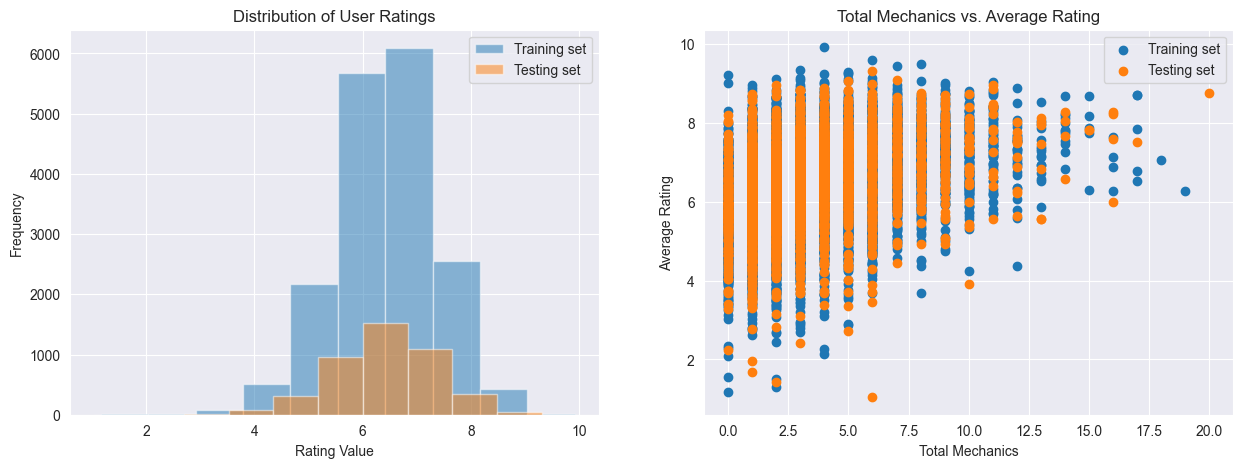

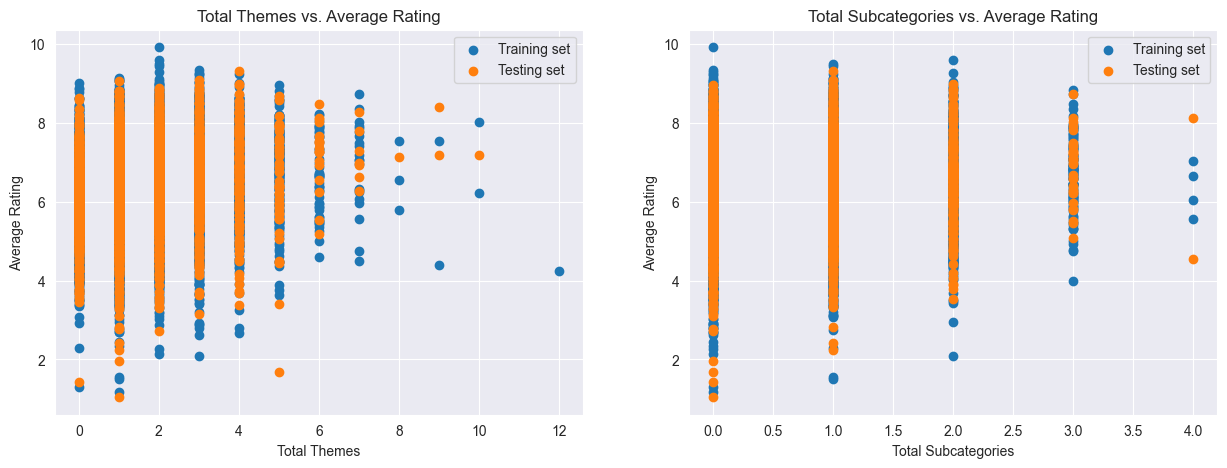

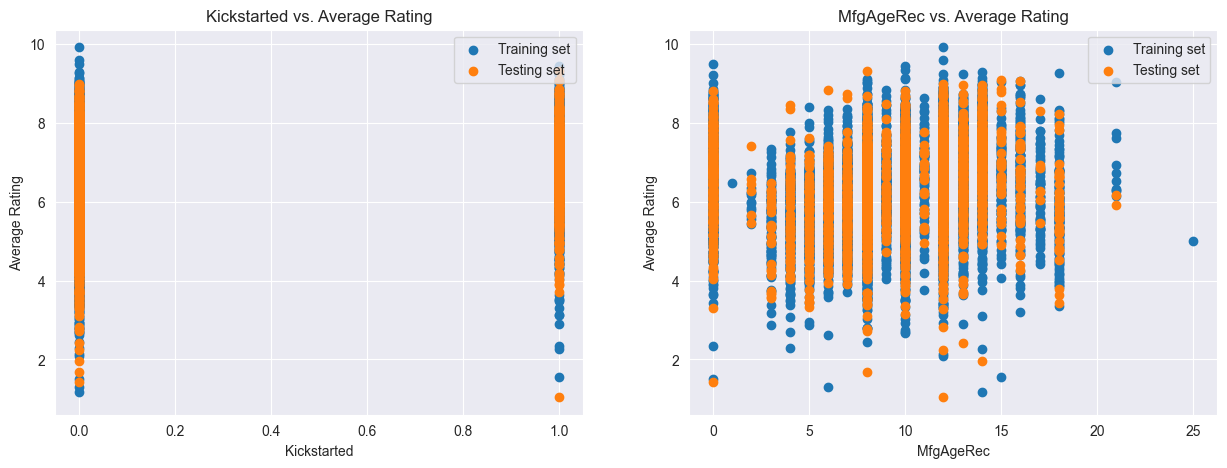

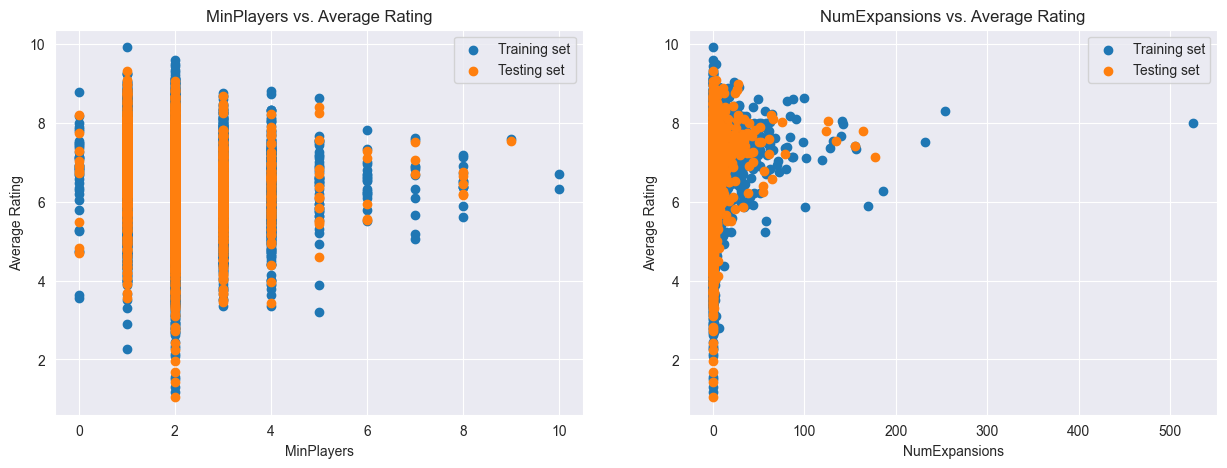

In [38]:
# Visualize the Mechanic, Theme, Subcategory, and Game features split
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(y_train, bins=10, alpha=0.5, label='Training set')
ax[0].hist(y_test, bins=10, alpha=0.5, label='Testing set')
ax[0].set_title('Distribution of User Ratings')
ax[0].set_xlabel('Rating Value')
ax[0].set_ylabel('Frequency')
ax[0].legend(loc='upper right')

ax[1].scatter(X_train['TotalMechanics'], y_train, label='Training set')
ax[1].scatter(X_test['TotalMechanics'], y_test, label='Testing set')
ax[1].set_title('Total Mechanics vs. Average Rating')
ax[1].set_xlabel('Total Mechanics')
ax[1].set_ylabel('Average Rating')
ax[1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(X_train['TotalThemes'], y_train, label='Training set')
ax[0].scatter(X_test['TotalThemes'], y_test, label='Testing set')
ax[0].set_title('Total Themes vs. Average Rating')
ax[0].set_xlabel('Total Themes')
ax[0].set_ylabel('Average Rating')
ax[0].legend(loc='upper right')

ax[1].scatter(X_train['TotalSubcategories'], y_train, label='Training set')
ax[1].scatter(X_test['TotalSubcategories'], y_test, label='Testing set')
ax[1].set_title('Total Subcategories vs. Average Rating')
ax[1].set_xlabel('Total Subcategories')
ax[1].set_ylabel('Average Rating')
ax[1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(X_train['Kickstarted'], y_train, label='Training set')
ax[0].scatter(X_test['Kickstarted'], y_test, label='Testing set')
ax[0].set_title('Kickstarted vs. Average Rating')
ax[0].set_xlabel('Kickstarted')
ax[0].set_ylabel('Average Rating')
ax[0].legend(loc='upper right')

ax[1].scatter(X_train['MfgAgeRec'], y_train, label='Training set')
ax[1].scatter(X_test['MfgAgeRec'], y_test, label='Testing set')
ax[1].set_title('MfgAgeRec vs. Average Rating')
ax[1].set_xlabel('MfgAgeRec')
ax[1].set_ylabel('Average Rating')
ax[1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(X_train['MinPlayers'], y_train, label='Training set')
ax[0].scatter(X_test['MinPlayers'], y_test, label='Testing set')
ax[0].set_title('MinPlayers vs. Average Rating')
ax[0].set_xlabel('MinPlayers')
ax[0].set_ylabel('Average Rating')
ax[0].legend(loc='upper right')

ax[1].scatter(X_train['NumExpansions'], y_train, label='Training set')
ax[1].scatter(X_test['NumExpansions'], y_test, label='Testing set')
ax[1].set_title('NumExpansions vs. Average Rating')
ax[1].set_xlabel('NumExpansions')
ax[1].set_ylabel('Average Rating')
ax[1].legend(loc='upper right')
plt.show()



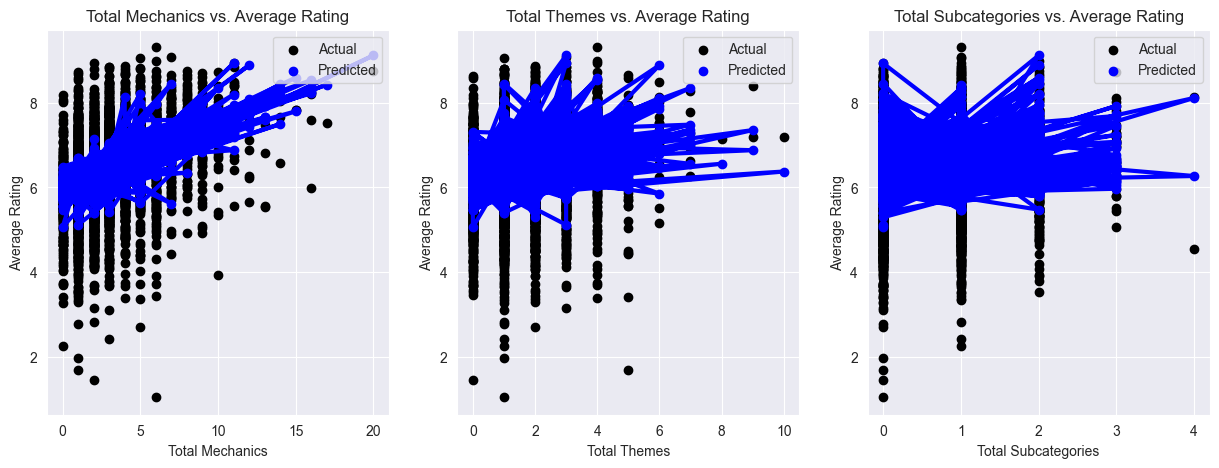

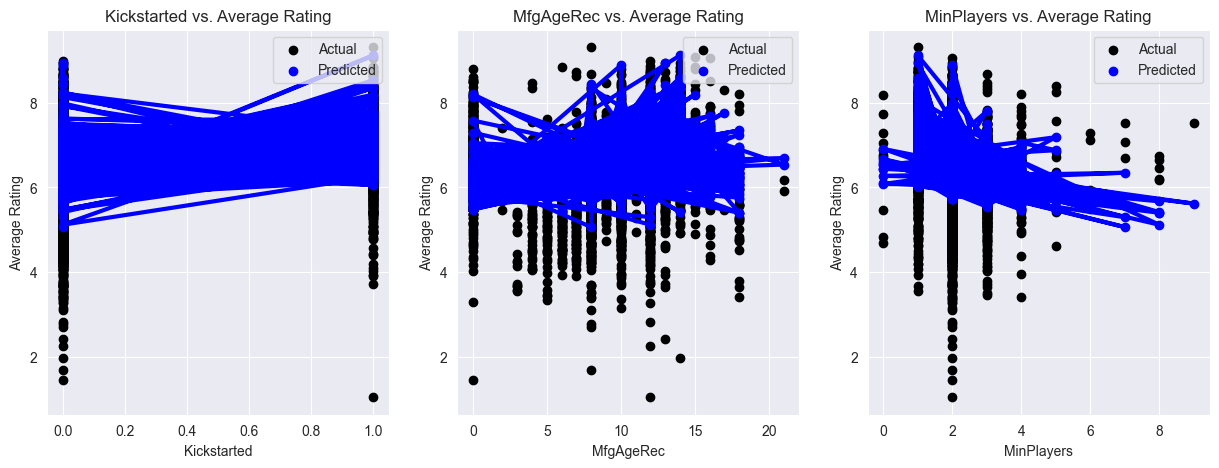

Coefficients: 
 [ 0.2755862   0.02716637 -0.17863008  0.01060711  0.12220568  0.00117923
 -0.01355011]
Mean squared error: 0.76
Coefficient of determination: 0.18


In [39]:
# Create a linear regression model
model = LinearRegression()

# Train the model using the training sets
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot outputs
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(X_test['TotalMechanics'], y_test, color='black', label='Actual')
ax[0].scatter(X_test['TotalMechanics'], y_pred, color='blue', label='Predicted')
ax[0].plot(X_test['TotalMechanics'], y_pred, color='blue', linewidth=3)
ax[0].set_title('Total Mechanics vs. Average Rating')
ax[0].set_xlabel('Total Mechanics')
ax[0].set_ylabel('Average Rating')
ax[0].legend(loc='upper right')

ax[1].scatter(X_test['TotalThemes'], y_test, color='black', label='Actual')
ax[1].scatter(X_test['TotalThemes'], y_pred, color='blue', label='Predicted')
ax[1].plot(X_test['TotalThemes'], y_pred, color='blue', linewidth=3)
ax[1].set_title('Total Themes vs. Average Rating')
ax[1].set_xlabel('Total Themes')
ax[1].set_ylabel('Average Rating')
ax[1].legend(loc='upper right')

ax[2].scatter(X_test['TotalSubcategories'], y_test, color='black', label='Actual')
ax[2].scatter(X_test['TotalSubcategories'], y_pred, color='blue', label='Predicted')
ax[2].plot(X_test['TotalSubcategories'], y_pred, color='blue', linewidth=3)
ax[2].set_title('Total Subcategories vs. Average Rating')
ax[2].set_xlabel('Total Subcategories')
ax[2].set_ylabel('Average Rating')
ax[2].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(X_test['Kickstarted'], y_test, color='black', label='Actual')
ax[0].scatter(X_test['Kickstarted'], y_pred, color='blue', label='Predicted')
ax[0].plot(X_test['Kickstarted'], y_pred, color='blue', linewidth=3)
ax[0].set_title('Kickstarted vs. Average Rating')
ax[0].set_xlabel('Kickstarted')
ax[0].set_ylabel('Average Rating')
ax[0].legend(loc='upper right')

ax[1].scatter(X_test['MfgAgeRec'], y_test, color='black', label='Actual')
ax[1].scatter(X_test['MfgAgeRec'], y_pred, color='blue', label='Predicted')
ax[1].plot(X_test['MfgAgeRec'], y_pred, color='blue', linewidth=3)
ax[1].set_title('MfgAgeRec vs. Average Rating')
ax[1].set_xlabel('MfgAgeRec')
ax[1].set_ylabel('Average Rating')
ax[1].legend(loc='upper right')

ax[2].scatter(X_test['MinPlayers'], y_test, color='black', label='Actual')
ax[2].scatter(X_test['MinPlayers'], y_pred, color='blue', label='Predicted')
ax[2].plot(X_test['MinPlayers'], y_pred, color='blue', linewidth=3)
ax[2].set_title('MinPlayers vs. Average Rating')
ax[2].set_xlabel('MinPlayers')
ax[2].set_ylabel('Average Rating')
ax[2].legend(loc='upper right')
plt.show()

# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % sk.metrics.mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % sk.metrics.r2_score(y_test, y_pred))


## Linear Regression Model Analysis (All Features)

These Coefficients correspond to `[Kickstarted, MfgAgeRec, MinPlayers, NumExpansions, TotalMechanics, TotalThemes, TotalSubcategories]` respectively. These reflect the amount of change each feature has on the average rating that was predicted per one-unit change in each respective feature. Further investigation or speculation on these could be insightful; for instance, `MinPlayers` has a value of `-.178`, which could imply that games with fewer players are preferred.   

The mean squared value and coefficient of determination show improvement over the same model with a more feature-rich dataset. The MSE has decreased from `.80` to `.76`, slightly improving prediction accuracy. The coefficient of determination has increased from `.13` to `.18`, meaning the model now explains 18% of the variance in the predicted average rating. These improvements on the previous model prove that adding the lesser-scored features was still worthwhile in improving model accuracy. Both also show room for improvement, possibly with even more features. 

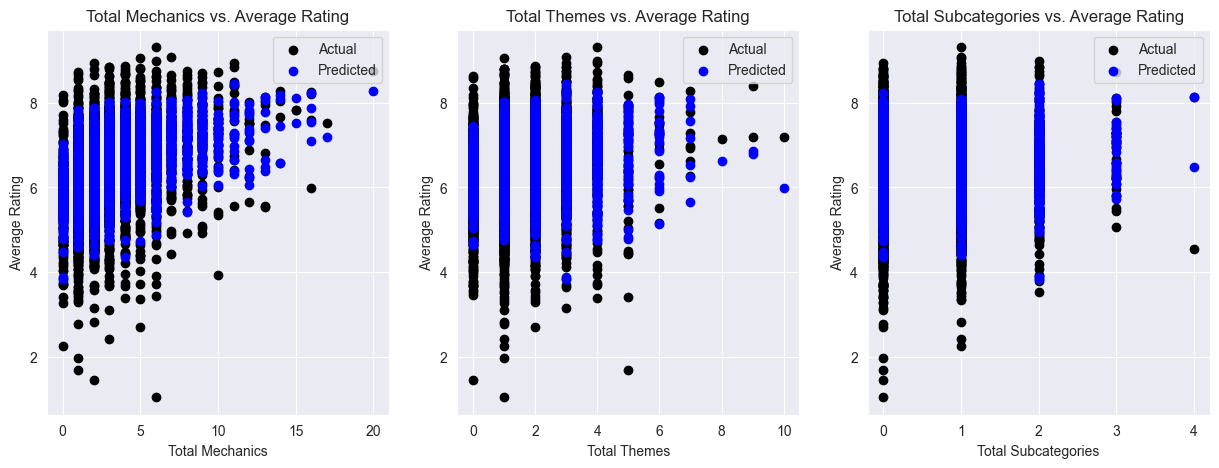

In [40]:
# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model using the training sets
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot outputs
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(X_test['TotalMechanics'], y_test, color='black', label='Actual')
ax[0].scatter(X_test['TotalMechanics'], y_pred, color='blue', label='Predicted')
ax[0].set_title('Total Mechanics vs. Average Rating')
ax[0].set_xlabel('Total Mechanics')
ax[0].set_ylabel('Average Rating')
ax[0].legend(loc='upper right')

ax[1].scatter(X_test['TotalThemes'], y_test, color='black', label='Actual')
ax[1].scatter(X_test['TotalThemes'], y_pred, color='blue', label='Predicted')
ax[1].set_title('Total Themes vs. Average Rating')
ax[1].set_xlabel('Total Themes')
ax[1].set_ylabel('Average Rating')
ax[1].legend(loc='upper right')

ax[2].scatter(X_test['TotalSubcategories'], y_test, color='black', label='Actual')
ax[2].scatter(X_test['TotalSubcategories'], y_pred, color='blue', label='Predicted')
ax[2].set_title('Total Subcategories vs. Average Rating')
ax[2].set_xlabel('Total Subcategories')
ax[2].set_ylabel('Average Rating')
ax[2].legend(loc='upper right')
plt.show()


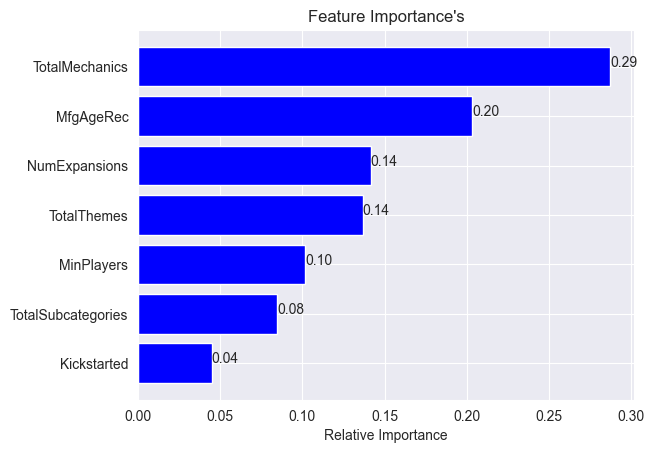

Mean Squared Error: 0.72
Coefficient of Determination (R^2): 0.22


In [41]:
# Extract feature importances
importances = model.feature_importances_

# Map these importances to their corresponding feature names
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))

# Sort the features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Plotting feature importances
features = list(feature_names)
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importance\'s')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
# Add annotations to each bar with the exact value of the importance
for index, value in enumerate(importances[indices]):
    plt.text(value, index, f'{value:.2f}')
plt.show()

# Calculate and print the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Calculate and print the Coefficient of Determination (R^2)
r2 = r2_score(y_test, y_pred)
print(f"Coefficient of Determination (R^2): {r2:.2f}")

## Random Forest Regressor Model Analysis (All Features)

The feature importance values for this model have a different meaning for the random forest regressor. Each value here represents the relative importance of the feature, with the sum of all feature importances equaling 1. This was very interesting because it showed that without actual model training and testing, the assumed importance of the features was incorrect. Based purely on the math from earlier, the [TotalMechanics, TotalSubcategories, TotalThemes] features were the most correlated to the average rating and thus should have had the most impact on the prediction. Results in the Feature Importance graph show that the most important feature was still TotalMechanics. However, the second and third MfgAgeRec and NumExpansion had correlation values much lower than any of the Total features. 

The MSE and coefficient of determination show signs of model improvement. The MSE has decreased from .76 to .72, showing improvement in model prediction accuracy. The coefficient of determination increased from .18 to .22, demonstrating that this model has improved predictive power. Although both improved, these values again show signs of further model refinement. 

In [42]:
# Provide user with the ability to input game features and get a predicted average rating
# This will be done using the Random Forest Regressor model
# ["Kickstarted", "MfgAgeRec", "MinPlayers", "NumExpansions", "TotalMechanics", "TotalThemes",
#  "TotalSubcategories"]
feature_widgets = []
# start with totals
feature_widgets.append(widgets.IntSlider(value=0, min=0, max=200, step=1, description='Total Mechanics'))
feature_widgets.append(widgets.IntSlider(value=0, min=0, max=200, step=1, description='Total Themes'))
feature_widgets.append(widgets.IntSlider(value=0, min=0, max=200, step=1, description='Total Subcategories'))
# add the rest of the features
feature_widgets.append(widgets.Checkbox(value=False, description='Kickstarted'))
feature_widgets.append(widgets.IntSlider(value=0, min=0, max=100, step=1, description='MfgAgeRec'))
feature_widgets.append(widgets.IntSlider(value=0, min=0, max=100, step=1, description='MinPlayers'))
feature_widgets.append(widgets.IntSlider(value=0, min=0, max=100, step=1, description='NumExpansions'))

# Display the input widgets
display(*feature_widgets)

# Create a button to make a prediction
predict_button = widgets.Button(description="Make Prediction")
display(predict_button)

# Predicted Average Rating Label
predicted_rating_label = widgets.Label(value="")
display(predicted_rating_label)

# Create a function to get the input values and make a prediction
def on_predict_button_clicked(b):
    print("Making a prediction...")
    # Get the input values
    input_values = [feature_widget.value for feature_widget in feature_widgets]
    print(input_values)
    # Make a prediction
    predicted_rating = model.predict([input_values])[0]
    # Display the prediction
    print("The predicted average rating is: ", predicted_rating)
    predicted_rating_label.value = f"The predicted average rating is: {predicted_rating:.2f}"
    
# Link the button to the function
predict_button.on_click(on_predict_button_clicked)


IntSlider(value=0, description='Total Mechanics', max=200)

IntSlider(value=0, description='Total Themes', max=200)

IntSlider(value=0, description='Total Subcategories', max=200)

Checkbox(value=False, description='Kickstarted')

IntSlider(value=0, description='MfgAgeRec')

IntSlider(value=0, description='MinPlayers')

IntSlider(value=0, description='NumExpansions')

Button(description='Make Prediction', style=ButtonStyle())

Label(value='')